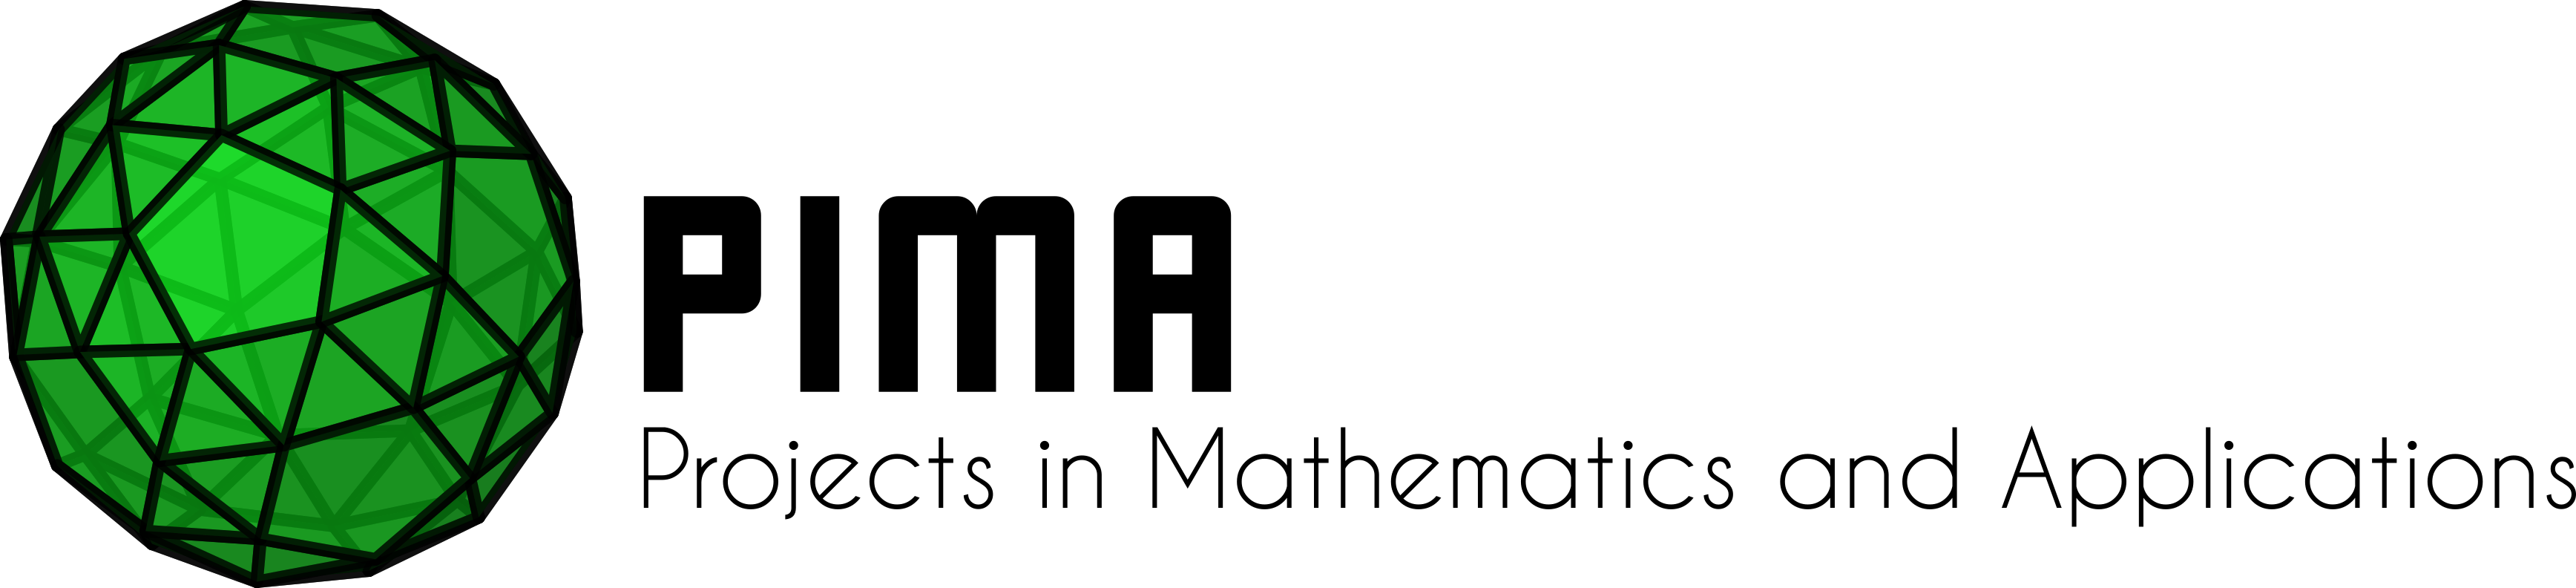

# Bài tập lập trình: Ước lượng tham số của hỗn hợp Gaussian

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def multivariate_normal(x, mu, sigma):
  return (1 / np.sqrt(np.linalg.det(2 * np.pi * sigma))) * np.exp(-0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu))

def generate_samples(num_samples, pi, mu, sigma):
  '''
  Đầu vào:
  * num_samples: số lượng mẫu muốn tạo
  * pi: danh sách xác suất
  * mu: danh sách trung bình
  * sigma: danh sách ma trận hiệp phương sai
  Trả lại: danh sách các mẫu tạo thành
  '''
  samples = []
  for _ in range(num_samples):
    sample = np.random.choice(len(pi), p=pi)
    mean = mu[sample]
    cov = sigma[sample]
    samples.append(np.random.multivariate_normal(mean, cov))
  return np.array(samples)

In [ ]:
def EM_for_GMM(x, K):
  '''
  Đầu vào:
  * x: danh sách các mẫu
  * K: số lượng thành phần của hỗn hợp
  Trả lại:
  * pi: danh sách xác suất
  * mu: danh sách trung bình
  * sigma: danh sách ma trận hiệp phương sai
  '''
  N, D = x.shape
  # Khởi tạo tham số ban đầu
  np.random.seed(42)  # Để tái lập kết quả
  pi = np.ones(K) / K  # Xác suất trộn ban đầu đều
  mu = x[np.random.choice(N, K, replace=False)]  # Chọn ngẫu nhiên K điểm làm trung bình
  sigma = np.array([np.cov(x.T) for _ in range(K)])  # Ma trận hiệp phương sai ban đầu từ dữ liệu
  for _ in range(50): #Cài đặt vòng lặp đơn thuần trước
# E-step: Tính xác suất trách nhiệm gamma_ik
        gamma = np.zeros((N, K))
        for k in range(K):
            for i in range(N):
                gamma[i, k] = pi[k] * multivariate_normal(x[i], mu[k], sigma[k])
        # Chuẩn hóa gamma để tổng xác suất bằng 1
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        # M-step: Cập nhật tham số
        Nk = np.sum(gamma, axis=0)  # Tổng trách nhiệm cho mỗi thành phần
        # Cập nhật pi
        pi = Nk / N
        # Cập nhật mu
        mu = np.zeros((K, D))
        for k in range(K):
            for i in range(N):
                mu[k] += gamma[i, k] * x[i]
            mu[k] /= Nk[k]
        # Cập nhật sigma
        sigma = np.zeros((K, D, D))
        for k in range(K):
            for i in range(N):
                diff = (x[i] - mu[k]).reshape(-1, 1)
                sigma[k] += gamma[i, k] * (diff @ diff.T)
            sigma[k] /= Nk[k]
            # Đảm bảo ma trận hiệp phương sai khả định dương
            sigma[k] += 1e-6 * np.eye(D)

  return pi, mu, sigma

def plot_covariance_ellipses(mu, sigma, ax=None, colors=None, alpha=0.5):
    """
    Vẽ các phân phối chuẩn trên đồ thị. Không cần chỉnh.
    """
    if ax is None:
        ax = plt.gca()

    if colors is None:
        colors = plt.cm.get_cmap('tab10', mu.shape[0])

    for i in range(mu.shape[0]):
        mean = mu[i]
        cov = sigma[i]

        eigvals, eigvecs = np.linalg.eigh(cov)

        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        angle = np.arctan2(*eigvecs[:, 0][::-1])
        width, height = 3 * np.sqrt(eigvals)

        ell = plt.matplotlib.patches.Ellipse(mean, width, height, angle=np.degrees(angle),
                                             edgecolor=colors(i), facecolor='none', lw=2, alpha=alpha)
        ax.add_patch(ell)

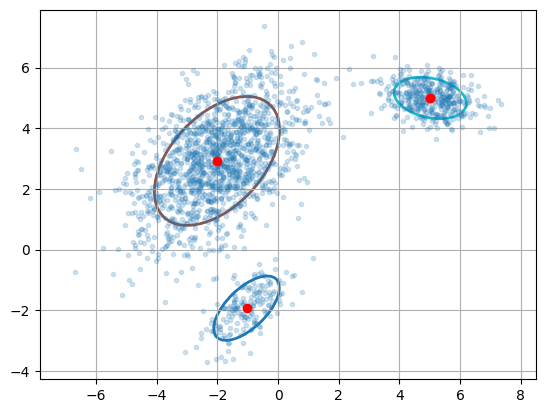

In [ ]:
x = generate_samples(
    2000,
    [0.1, 0.2, 0.7],
    [[-1, -2], [5, 5], [-2, 3]],
    [
        [[0.5, 0.3], [0.3, 0.5]],
        [[0.6, -0.1], [-0.1, 0.2]],
        [[2, 1], [1, 2]]
    ]
    )

pi, mu, sigma = EM_for_GMM(x, 3)
plot_covariance_ellipses(mu, sigma, colors=plt.get_cmap('tab10', len(mu)), alpha=1)
plt.plot(x[:, 0], x[:, 1], '.', alpha=0.2)
plt.plot(mu[:, 0], mu[:, 1], 'ro')
plt.axis('equal')
plt.grid()
plt.show()